In [1]:
from trace_process_utils import *
from scipy.stats import pearsonr
from tqdm import tqdm
import cupy as cp
import numpy as np


mpl.rcParams['figure.dpi'] = 250
plt.rc('text', usetex=False)

from pprint import pprint

## Original traces

In [2]:
trs_folder = "/mnt/jbod_main/public/qsp/trace_soc/"
trs_full = "rk-uboot-full.npz"
trs_path = trs_folder + trs_full

data_uboot_full = np.load(trs_path)

t_full = data_uboot_full['time_base']
trigger_trace_full = data_uboot_full['channel_A']
em_trace_full = data_uboot_full['channel_B']

print(t_full.shape)

(15625004,)


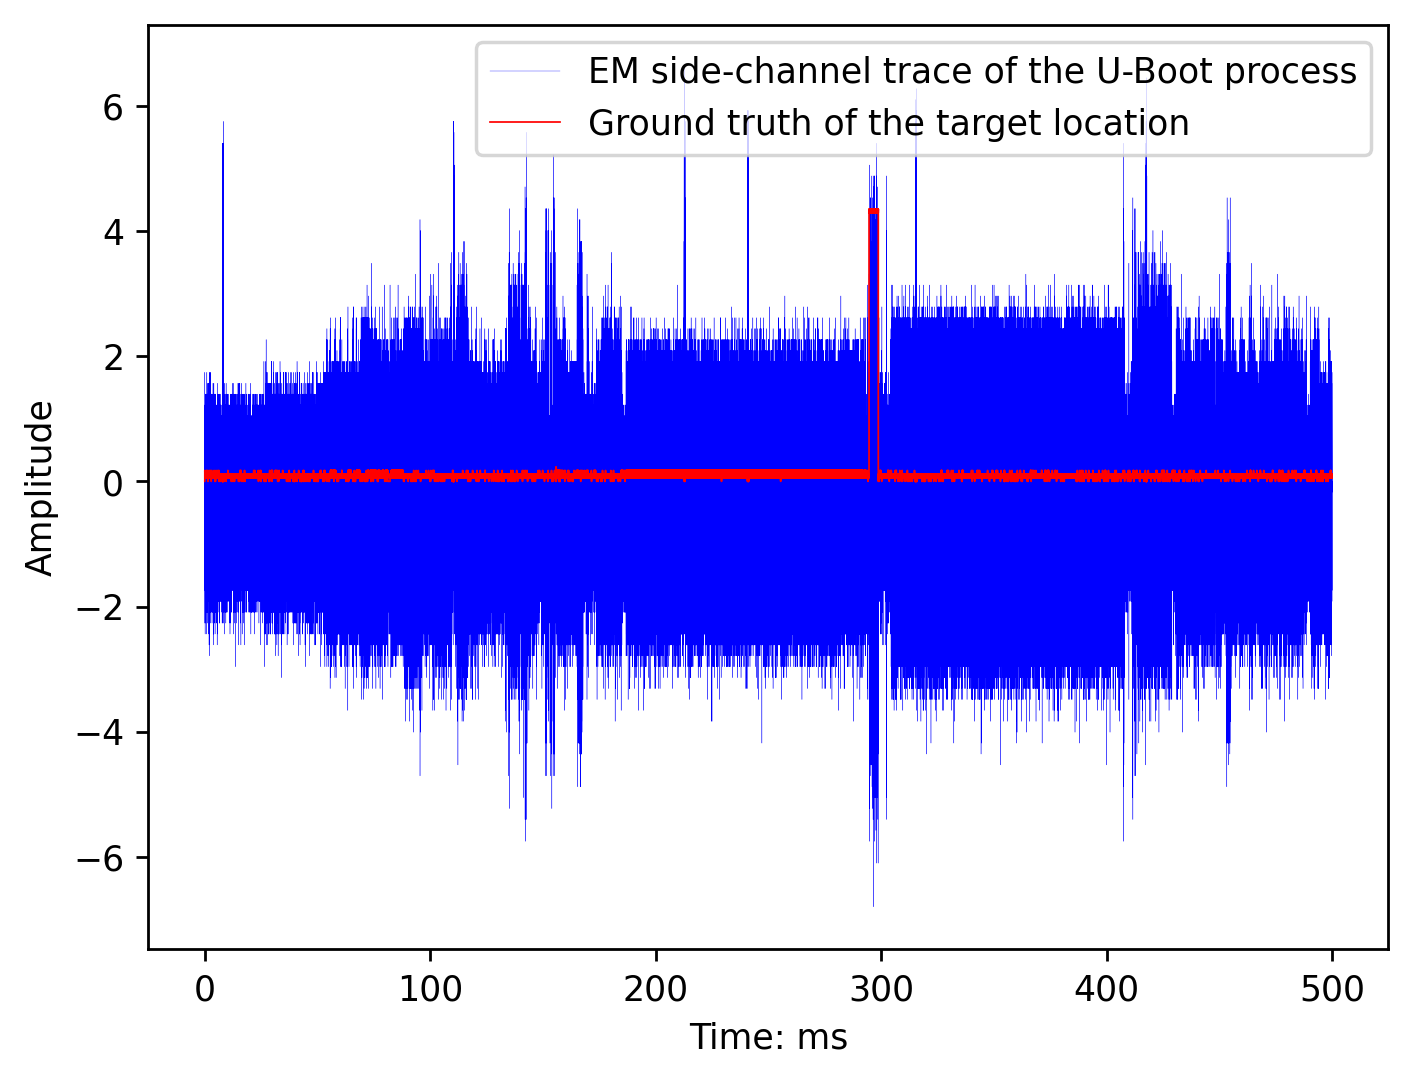

[9206718 9335118]


In [3]:
plt.plot(t_full, em_trace_full, linewidth = 0.1, color="blue", label="EM side-channel trace of the U-Boot process")
plt.plot(t_full, trigger_trace_full*1.3, linewidth=0.5, color="red", label="Ground truth of the target location")
plt.legend(loc="upper right")
plt.ylabel("Amplitude")
plt.xlabel("Time: ms")

plt.savefig("uboot-overall-trace-and-trigger.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0.1)

plt.show()

edges_full = get_trigger_edges_uniform(trigger_trace_full)
print(edges_full)

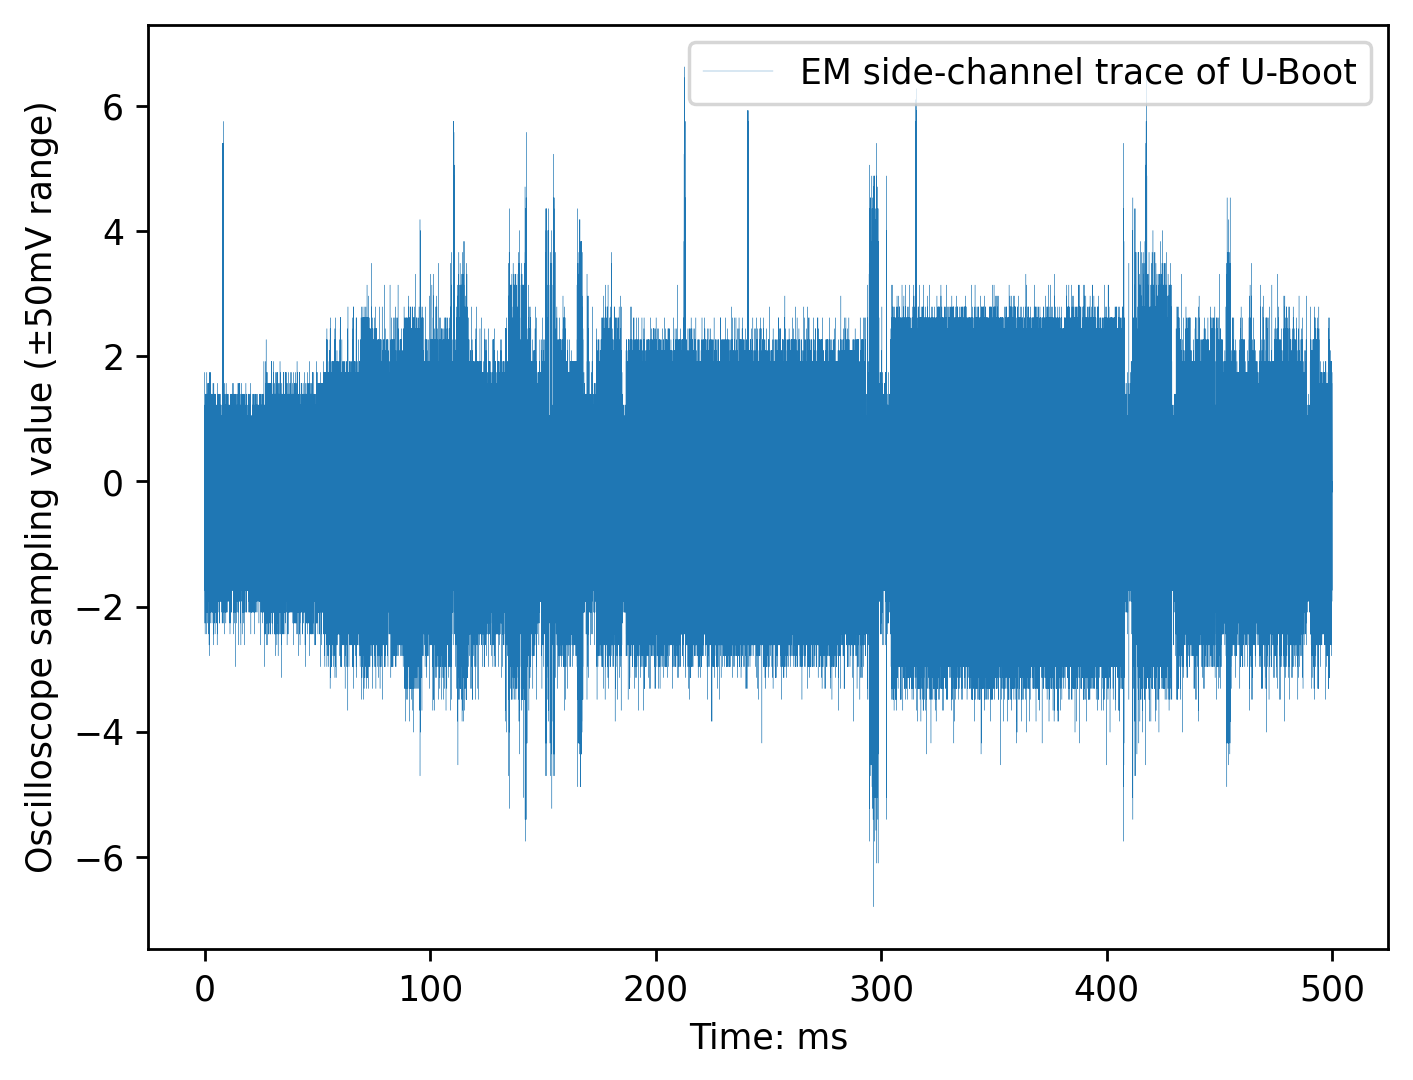

In [4]:
plt.plot(t_full, em_trace_full, linewidth = 0.1, label="EM side-channel trace of U-Boot")
plt.legend(loc="upper right")
plt.ylabel("Oscilloscope sampling value (±50mV range)")
plt.xlabel("Time: ms")
plt.savefig("uboot-overall-trace.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

shape:  (312504,)


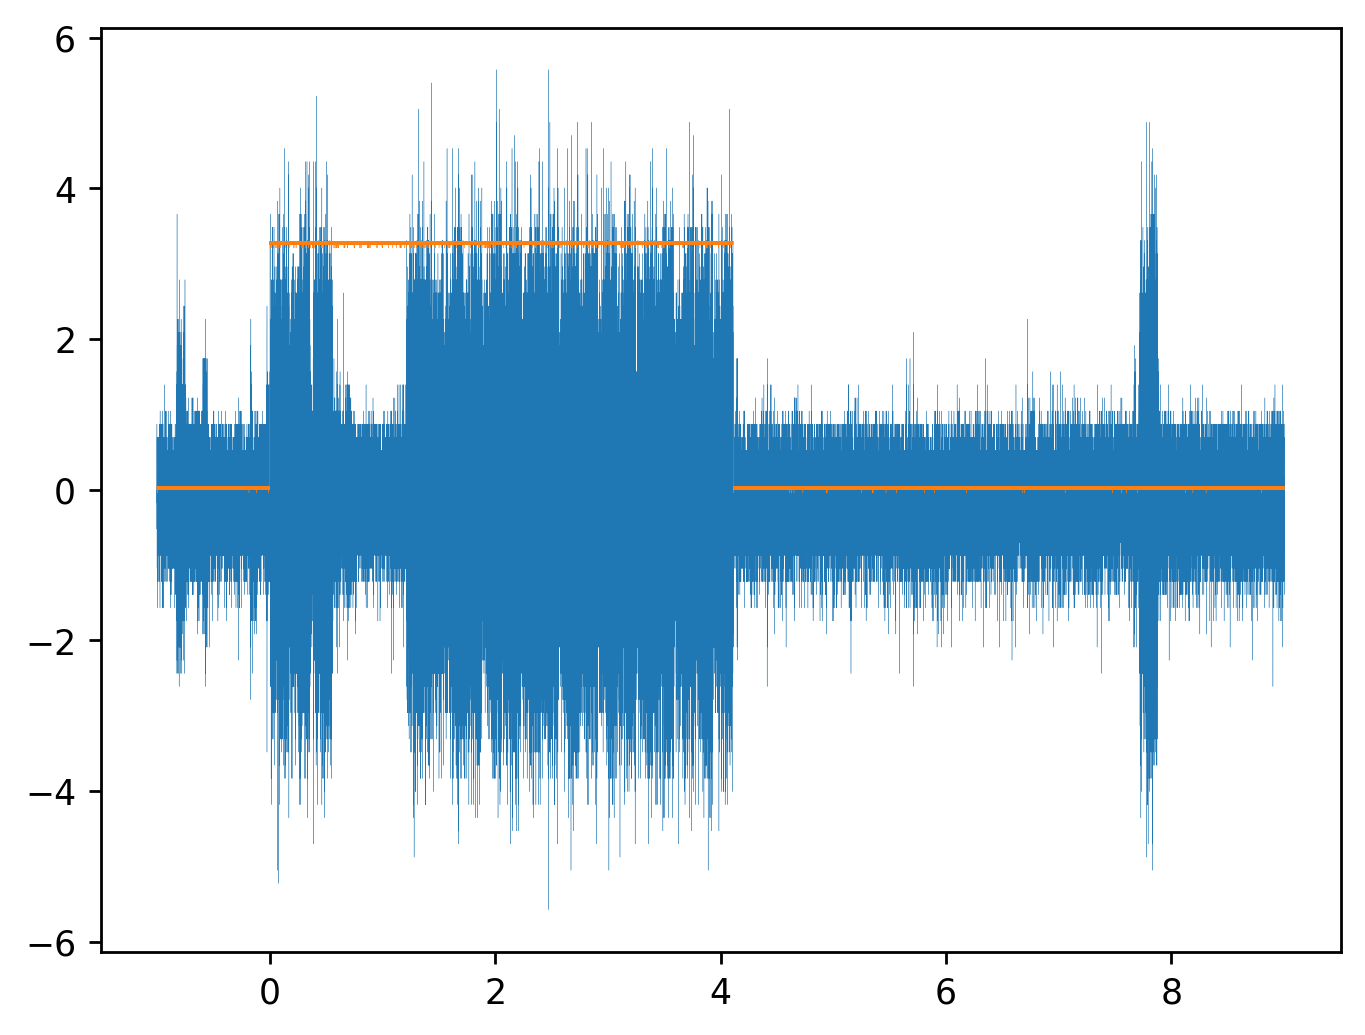

[ 31236 159771]


In [5]:
trs_folder = "/mnt/jbod_main/public/qsp/trace_soc/"
trs_target = "rk-uboot-target-template.npz"
trs_path = trs_folder + trs_target

data_uboot_target = np.load(trs_path)

t_target = data_uboot_target['time_base']
trigger_trace_target = data_uboot_target['channel_A']
em_trace_target = data_uboot_target['channel_B']

print("shape: ", t_target.shape)

plt.plot(t_target, em_trace_target, linewidth = 0.1)
plt.plot(t_target, trigger_trace_target, linewidth=0.1)
plt.show()

edges_target = get_trigger_edges_uniform(trigger_trace_target)
print(edges_target)

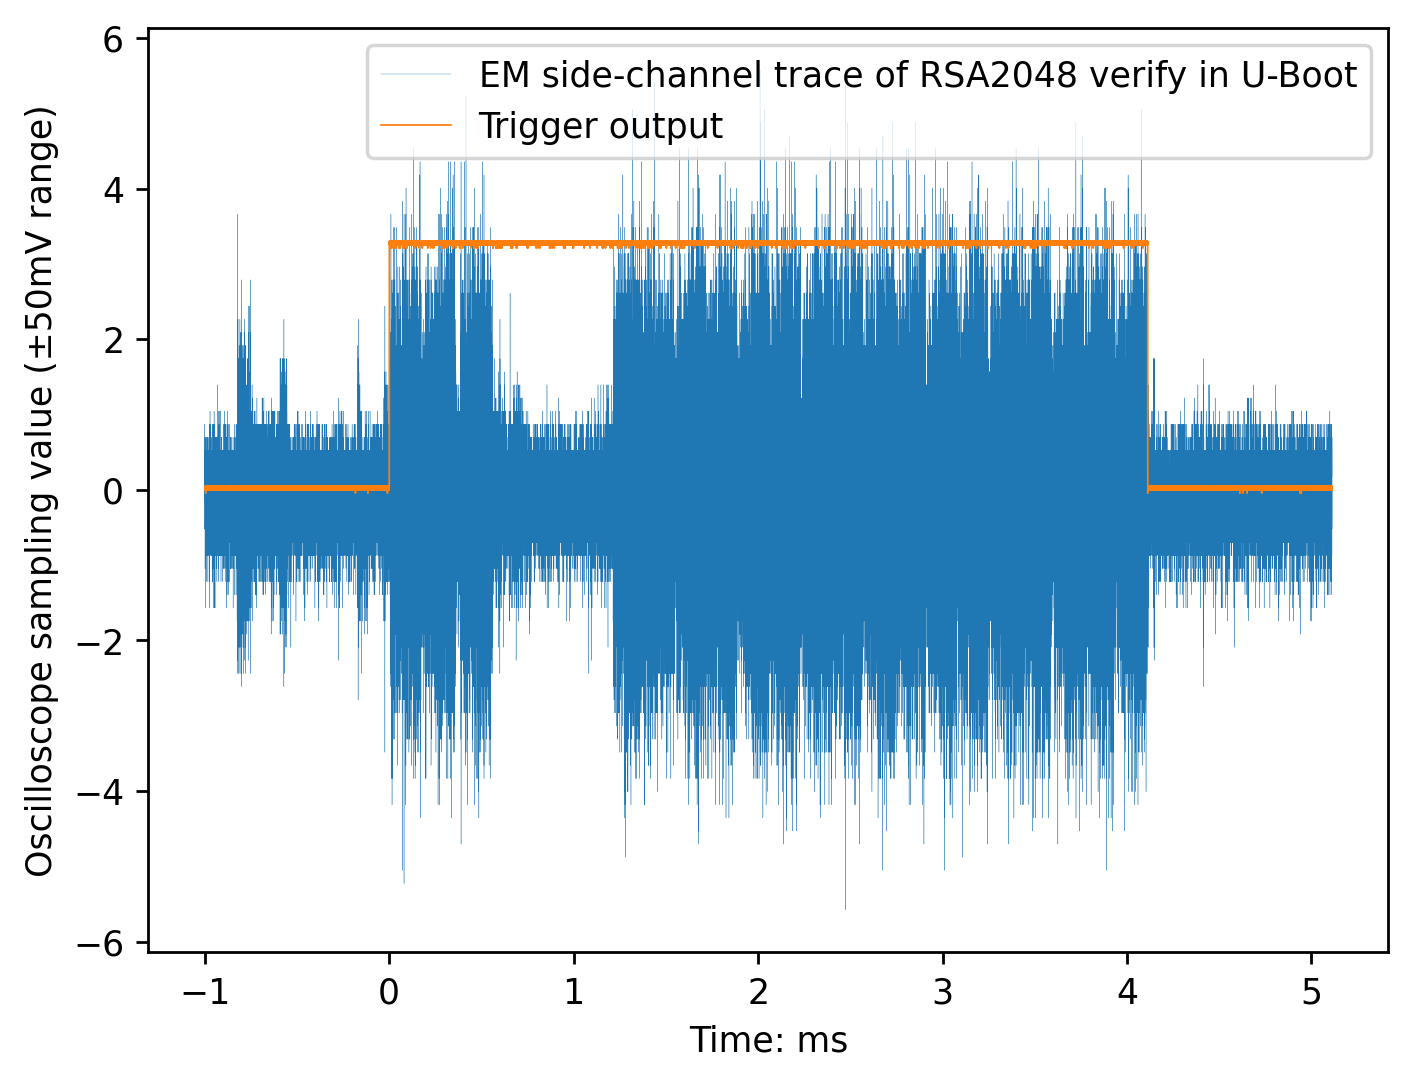

In [6]:
plt.plot(t_target[:159771+31236], em_trace_target[:159771+31236], linewidth = 0.1, label="EM side-channel trace of RSA2048 verify in U-Boot")
plt.plot(t_target[:159771+31236], trigger_trace_target[:159771+31236], linewidth=0.5, label="Trigger output")
plt.legend(loc="upper right")
plt.ylabel("Oscilloscope sampling value (±50mV range)")
plt.xlabel("Time: ms")
plt.savefig("uboot-rsa-trace.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

128535 128400


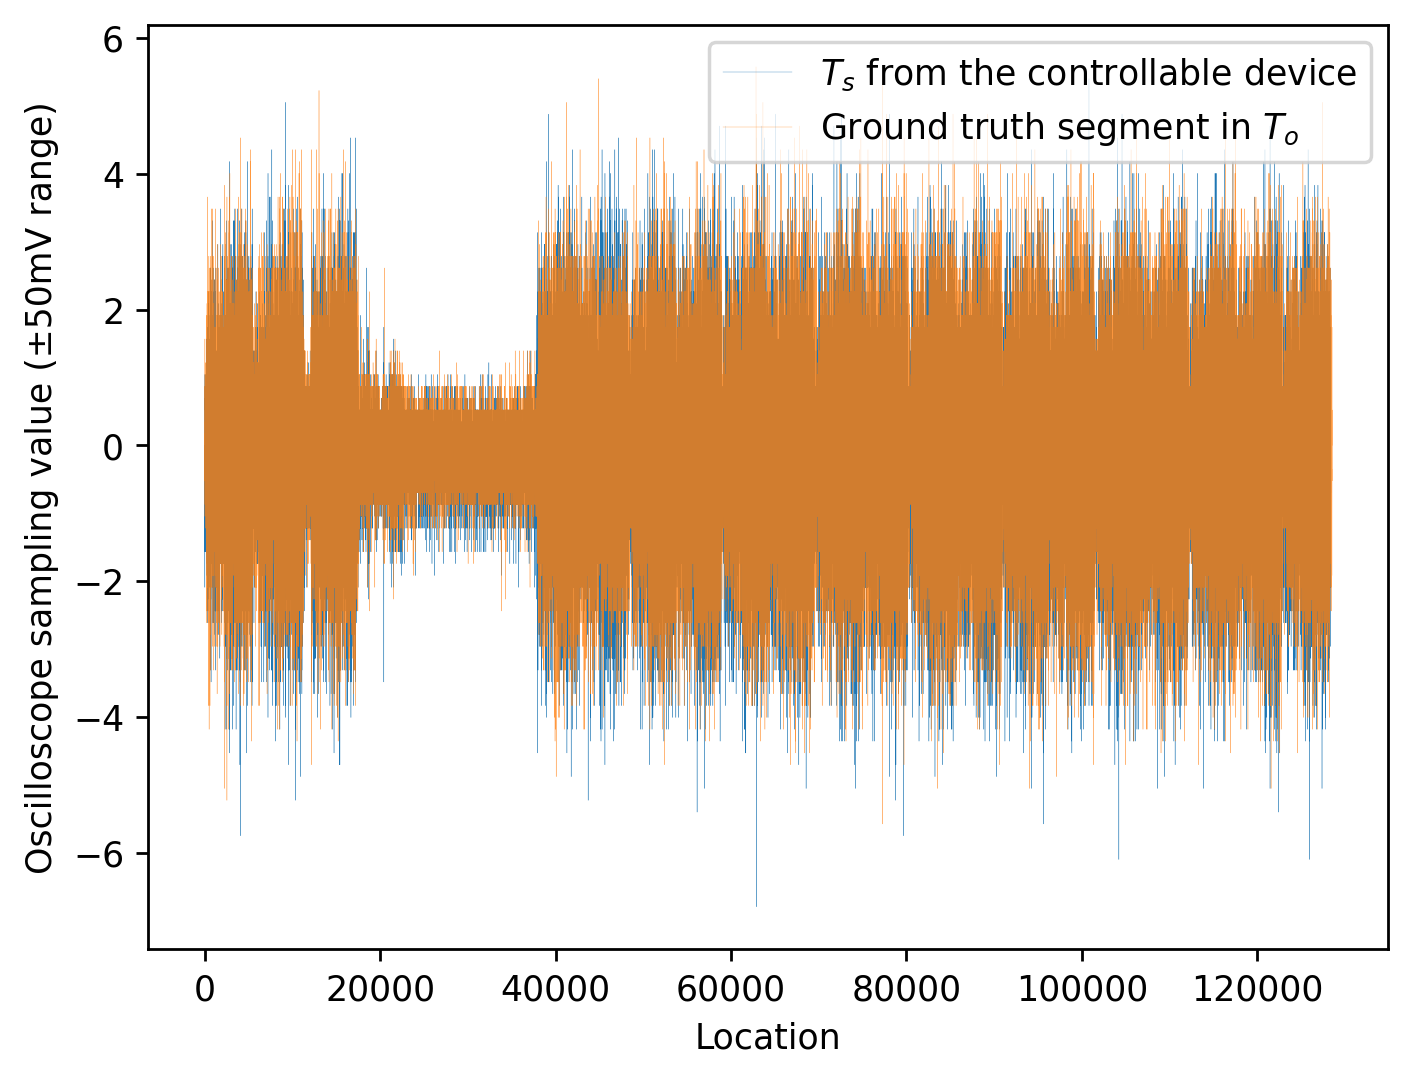

In [7]:
B= em_trace_target[edges_target[0]:edges_target[1]]
A= em_trace_full[edges_full[0]:edges_full[1]]

print(B.shape[0], A.shape[0])


plt.plot(A, linewidth=0.1, label=r"$T_{s}$ from the controllable device")
plt.plot(B, linewidth=0.1, alpha=0.8, label=r"Ground truth segment in $T_{o}$")
plt.ylabel("Oscilloscope sampling value (±50mV range)")
plt.xlabel("Location")
plt.legend(loc="upper right")
plt.savefig("uboot-rsa-trace-compare.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0.1)

plt.show()

128535 128400


100%|██████████| 135/135 [00:00<00:00, 1264.25it/s]

Time domain score:  [0.01377092 0.00436691 0.00071609 ... 0.         0.         0.        ]


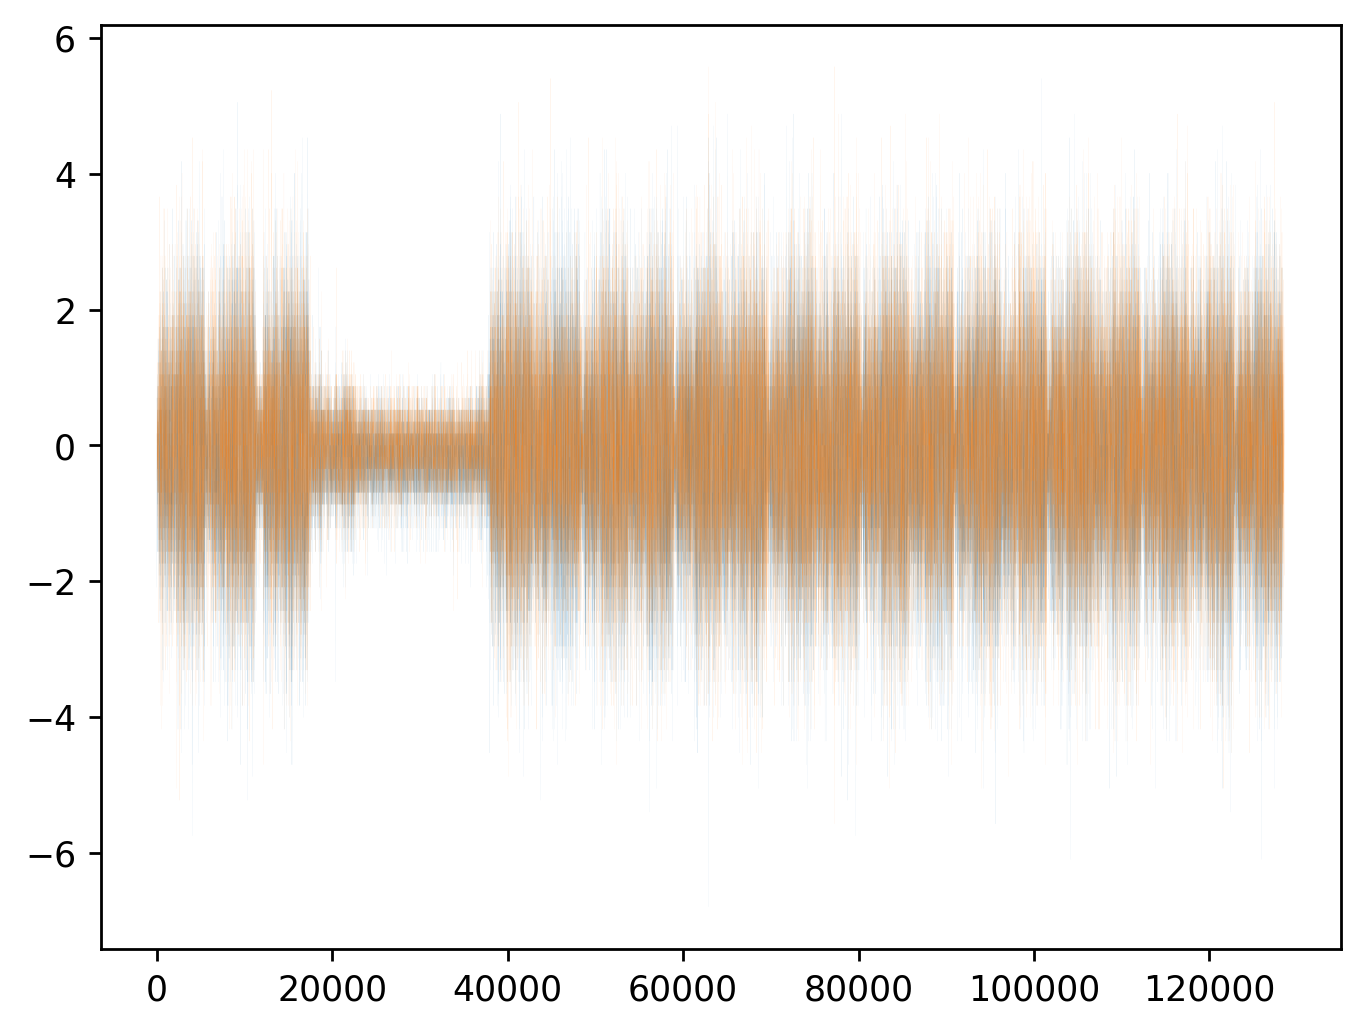

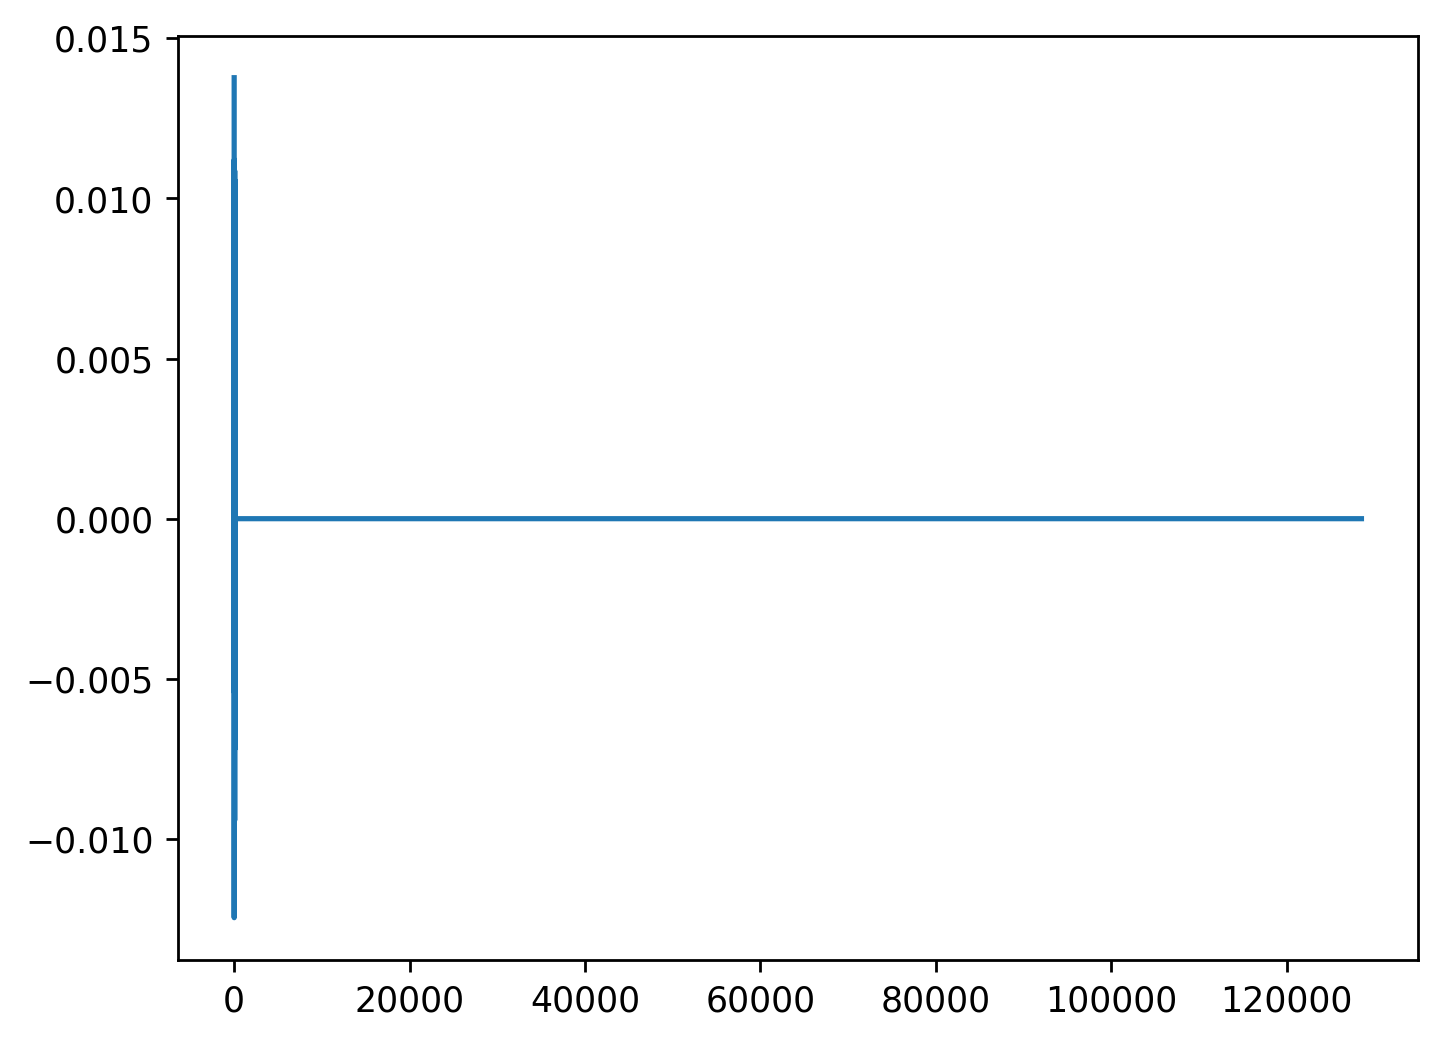

0.01377091734128312


In [8]:
B= em_trace_target[edges_target[-2]:edges_target[-1]]
A= em_trace_full[edges_full[-2]:edges_full[-1]]

print(B.shape[0], A.shape[0])

similar_score_time = np.zeros(B.shape[0])
target_len = A.shape[0]
# ~4 hours, unacceptable
for i in tqdm(range(0, B.shape[0]-A.shape[0])):
    width = min(target_len, B.shape[0] - i)
    score, _ = pearsonr(B[i:i+width], A[:width])
    similar_score_time[i] = score

print("Time domain score: ", similar_score_time)



plt.plot(A, linewidth=0.01)
plt.plot(B, linewidth=0.01)

plt.show()

plt.plot(similar_score_time)
plt.show()
print(np.max(similar_score_time))

(128535,) (25707,)


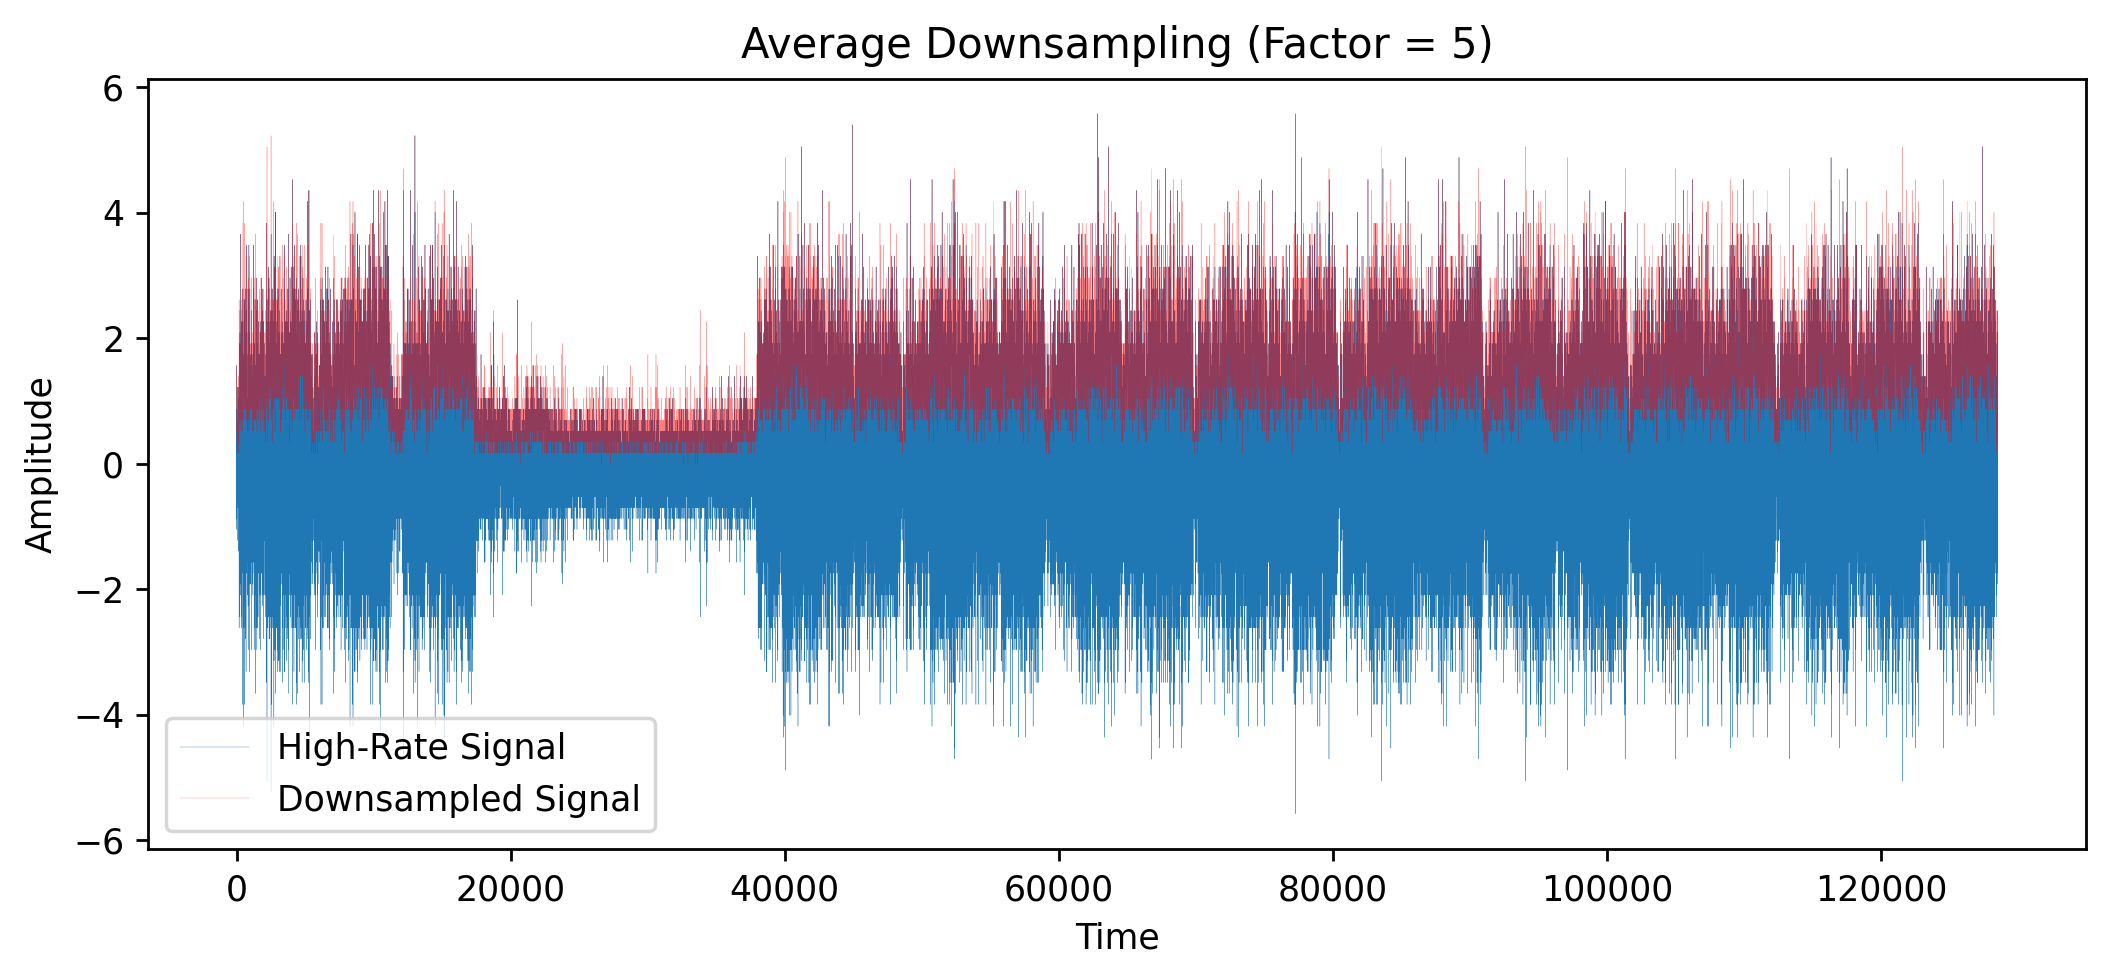

In [9]:
import scipy.signal as signal
from scipy.interpolate import interp1d

def extract_envelope_hilbert(signal_data):
    analytic_signal = signal.hilbert(signal_data)
    envelope = np.abs(analytic_signal)
    return envelope

def extract_envelope_peaks(signal_data):
    peaks, _ = signal.find_peaks(signal_data) 
    valleys, _ = signal.find_peaks(-signal_data) 
    
    peak_interp = interp1d(peaks, signal_data[peaks], kind='cubic', fill_value="extrapolate")
    valley_interp = interp1d(valleys, signal_data[valleys], kind='cubic', fill_value="extrapolate")

    envelope_upper = peak_interp(np.arange(len(signal_data)))
    envelope_lower = valley_interp(np.arange(len(signal_data)))

    return envelope_upper, envelope_lower

def downsample_average(signal, factor):
    N = len(signal)
    num_samples = N // factor 

    downsampled_signal = np.max(np.abs(signal[:num_samples * factor].reshape(-1, factor)), axis=1)
    return downsampled_signal

high_rate_signal = em_trace_target[edges_target[-2]:edges_target[-1]]
t = np.arange(high_rate_signal.shape[0])
t_high = np.arange(high_rate_signal.shape[0])

downsample_factor = 5
low_rate_signal = downsample_average(high_rate_signal, downsample_factor)

print(high_rate_signal.shape, low_rate_signal.shape)

plt.figure(figsize=(10, 4))
plt.plot(t_high, high_rate_signal, label="High-Rate Signal", linewidth=0.1)
plt.plot(np.linspace(0, t_high.shape[0], len(low_rate_signal)), low_rate_signal, '-', label="Downsampled Signal", color="red", linewidth=0.1, alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.title(f"Average Downsampling (Factor = {downsample_factor})")
plt.show()

15625004 128535
num_blocks: 60534
219759 0.14356662
1665452 104919.71


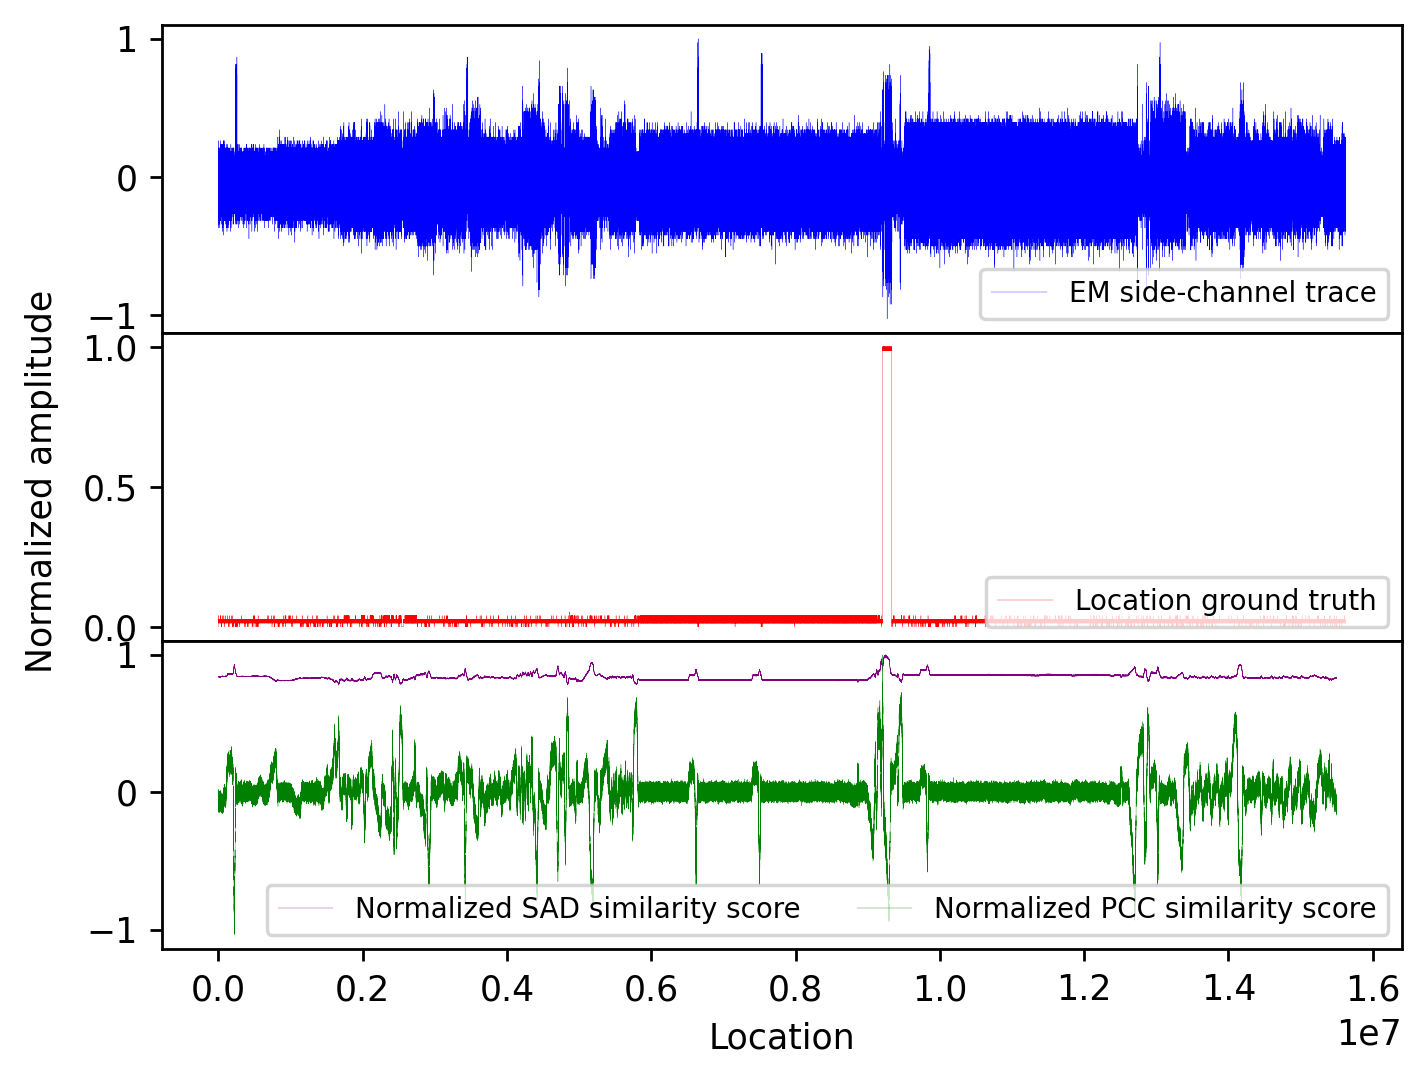

In [15]:
def similar_index_freq(x1, y1, x2, y2):
    # make sure x1 is longer
    if len(x1)<len(x2):
        x1, y1, x2, y2 = x2, y2, x1, y1
    y2_new = np.interp(x1*(x2[-1]/x1[-1]), x2, y2)
    score, pvalue = pearsonr(y1, y2_new)
    return score

def similar_index_freq_sad(x1, y1, x2, y2):
    # make sure x1 is longer
    if len(x1)<len(x2):
        x1, y1, x2, y2 = x2, y2, x1, y1
    y2_new = np.interp(x1*(x2[-1]/x1[-1]), x2, y2)
    score = np.sum(np.abs(y1-y2_new)/len(x1))
    return score

def similar_index_time(x1, y1, x2, y2):
    # make sure x1 is longer
    if len(x1)<len(x2):
        x1, y1, x2, y2 = x2, y2, x1, y1
    y2_new = np.interp(x1*(x2[-1]/x1[-1]), x2, y2)
    score, pvalue = pearsonr(y1, y2_new)
    return score

def sliding_sad(A, B):
    M = A.shape[0]
    windows = cp.lib.stride_tricks.sliding_window_view(B, window_shape=M)
    sad = cp.sum(cp.abs(windows - A), axis=1)
    return sad

def sliding_pearson(A, B):
    M = A.shape[0]
    windows = cp.lib.stride_tricks.sliding_window_view(B, window_shape=M)
    A_mean = cp.mean(A)
    A_std = cp.std(A)
    windows_mean = cp.mean(windows, axis=1)
    windows_std = cp.std(windows, axis=1)
    cov = cp.sum((A - A_mean) * (windows - windows_mean[:, None]), axis=1)
    pearson = cov / (M * A_std * windows_std)
    return pearson

# CUDA 核函数
pearson_kernel = cp.RawKernel(r'''
extern "C" __global__
void pearson_correlation(const float *A, const float *B, float *results, int A_size, int B_size) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int num_windows = B_size - A_size + 1;

    if (idx < num_windows) {
        float sum_A = 0.0, sum_B = 0.0, sum_AB = 0.0;
        float sum_A2 = 0.0, sum_B2 = 0.0;

        for (int i = 0; i < A_size; i++) {
            float a = A[i];
            float b = B[idx + i];
            sum_A += a;
            sum_B += b;
            sum_AB += a * b;
            sum_A2 += a * a;
            sum_B2 += b * b;
        }

        float mean_A = sum_A / A_size;
        float mean_B = sum_B / A_size;
        float std_A = sqrt(sum_A2 / A_size - mean_A * mean_A);
        float std_B = sqrt(sum_B2 / A_size - mean_B * mean_B);

        if (std_A > 1e-6 && std_B > 1e-6) {
            results[idx] = (sum_AB / A_size - mean_A * mean_B) / (std_A * std_B);
        } else {
            results[idx] = -1.0;
        }
    }
}
''', 'pearson_correlation')

def pearson_correlation_single_gpu(A, B):
    M = A.shape[0] 
    N = B.shape[0] 
    print(N, M)
    num_windows = N - M + 1

    A_gpu = cp.array(A, dtype=cp.float32)
    B_gpu = cp.array(B, dtype=cp.float32)

    results_gpu = cp.zeros(num_windows, dtype=cp.float32)
    threads_per_block = 256
    num_blocks = (num_windows + threads_per_block - 1) // threads_per_block
    print(f"num_blocks: {num_blocks}")
    pearson_kernel((num_blocks,), (threads_per_block,), (A_gpu, B_gpu, results_gpu, M, N))
    results = results_gpu.get()
    best_index = int(np.argmin(results))

    return best_index, results

sad_kernel = cp.RawKernel(r'''
extern "C" __global__
void sad_similarity(const float *A, const float *B, float *results, int A_size, int B_size) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int num_windows = B_size - A_size + 1;

    if (idx < num_windows) {
        float sad_value = 0.0;

        for (int i = 0; i < A_size; i++) {
            sad_value += fabsf(A[i] - B[idx + i]);
        }

        results[idx] = sad_value;
    }
}
''', 'sad_similarity')

def sad_similarity_single_gpu(A, B):
    M = A.shape[0]
    N = B.shape[0]
    num_windows = N - M + 1
    A_gpu = cp.array(A, dtype=cp.float32)
    B_gpu = cp.array(B, dtype=cp.float32)
    results_gpu = cp.zeros(num_windows, dtype=cp.float32)
    threads_per_block = 256
    num_blocks = (num_windows + threads_per_block - 1) // threads_per_block
    sad_kernel((num_blocks,), (threads_per_block,), (A_gpu, B_gpu, results_gpu, M, N))
    results = results_gpu.get()
    best_index = int(np.argmin(results))

    return best_index, results

# downsample_factor = 1
# A = downsample_average(em_trace_target[edges_target[-2]:edges_target[-1]], downsample_factor)
# B = downsample_average(em_trace_full, downsample_factor)
# C = downsample_average(trigger_trace_full, downsample_factor)

# A = em_trace_target[edges_target[-2]:edges_target[-1]]
# B = em_trace_full
# C = trigger_trace_full


A = np.abs(em_trace_target[edges_target[-2]:edges_target[-1]])
B = np.abs(em_trace_full)
C = np.abs(trigger_trace_full)

best_index_pcc, results_pcc = pearson_correlation_single_gpu(A, B)
best_index_sad, results_sad = sad_similarity_single_gpu(A, B)

print(best_index_pcc, np.max(results_pcc))
print(best_index_sad, np.max(results_sad))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, 
                                    gridspec_kw={'hspace': 0})
ax1.plot(em_trace_full/np.max(em_trace_full), color='blue', linewidth=0.1, label="EM side-channel trace")
ax1.legend(loc="lower right",  prop={'size': 8})
ax2.plot(C/np.max(C), color='red', linewidth=0.1, label="Location ground truth")
ax2.legend(loc="lower right",  prop={'size': 8})
ax3.plot(results_sad/np.max(results_sad), color='purple', linewidth=0.1, label="Normalized SAD similarity score")
ax3.plot(results_pcc/np.max(results_pcc), color='green', linewidth=0.1, label="Normalized PCC similarity score")
ax3.legend(loc="lower right", ncol=2, prop={'size': 8})
ax3.set_xlabel('Location')

fig.text(0.05, 0.5, 'Normalized amplitude', va='center', ha='center', rotation='vertical')

plt.savefig("uboot-sim-result.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0.1)

plt.show()

# similar_score_time = np.zeros(em_trace_full.shape[0])
# target_len = edges_target[-1] - edges_target[-2]
# # ~4 hours, unacceptable
# for i in tqdm(range(0, em_trace_full.shape[0])):
#     width = min(target_len, em_trace_full.shape[0] - i)
#     score, _ = pearsonr(em_trace_full[i:i+width], em_trace_target[:width])
#     similar_score_time[i] = score

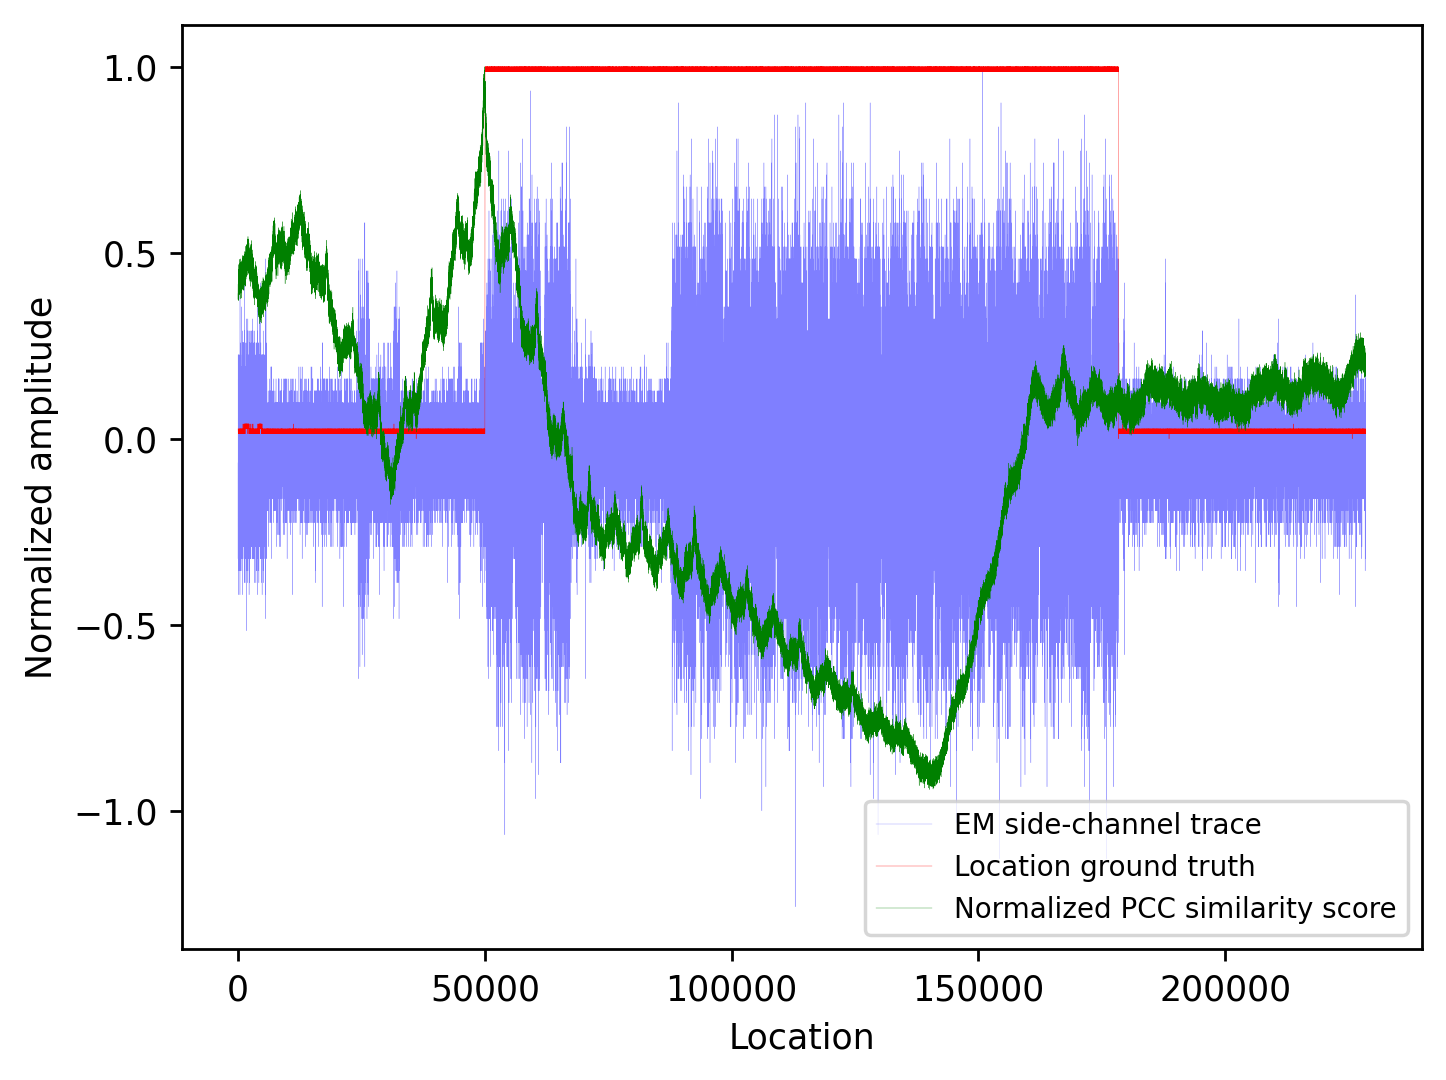

In [11]:
zoom_start = int(edges_full[-2]-0.05e6)
zoom_end = int(edges_full[-1]+0.05e6)
plt.plot(em_trace_full[zoom_start:zoom_end]/np.max(em_trace_full[zoom_start:zoom_end]), color='blue', linewidth=0.1, label="EM side-channel trace", alpha=0.5)
plt.plot(C[zoom_start:zoom_end]/np.max(C[zoom_start:zoom_end]), color='red', linewidth=0.1, label="Location ground truth")
plt.plot(results_pcc[zoom_start:zoom_end]/np.max(results_pcc[zoom_start:zoom_end]), color='green', linewidth=0.1, label="Normalized PCC similarity score")
plt.xlabel("Location")
plt.ylabel("Normalized amplitude")
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig("uboot-pcc-result-zoomed-in.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0.1)

plt.show()

1665452 104919.71


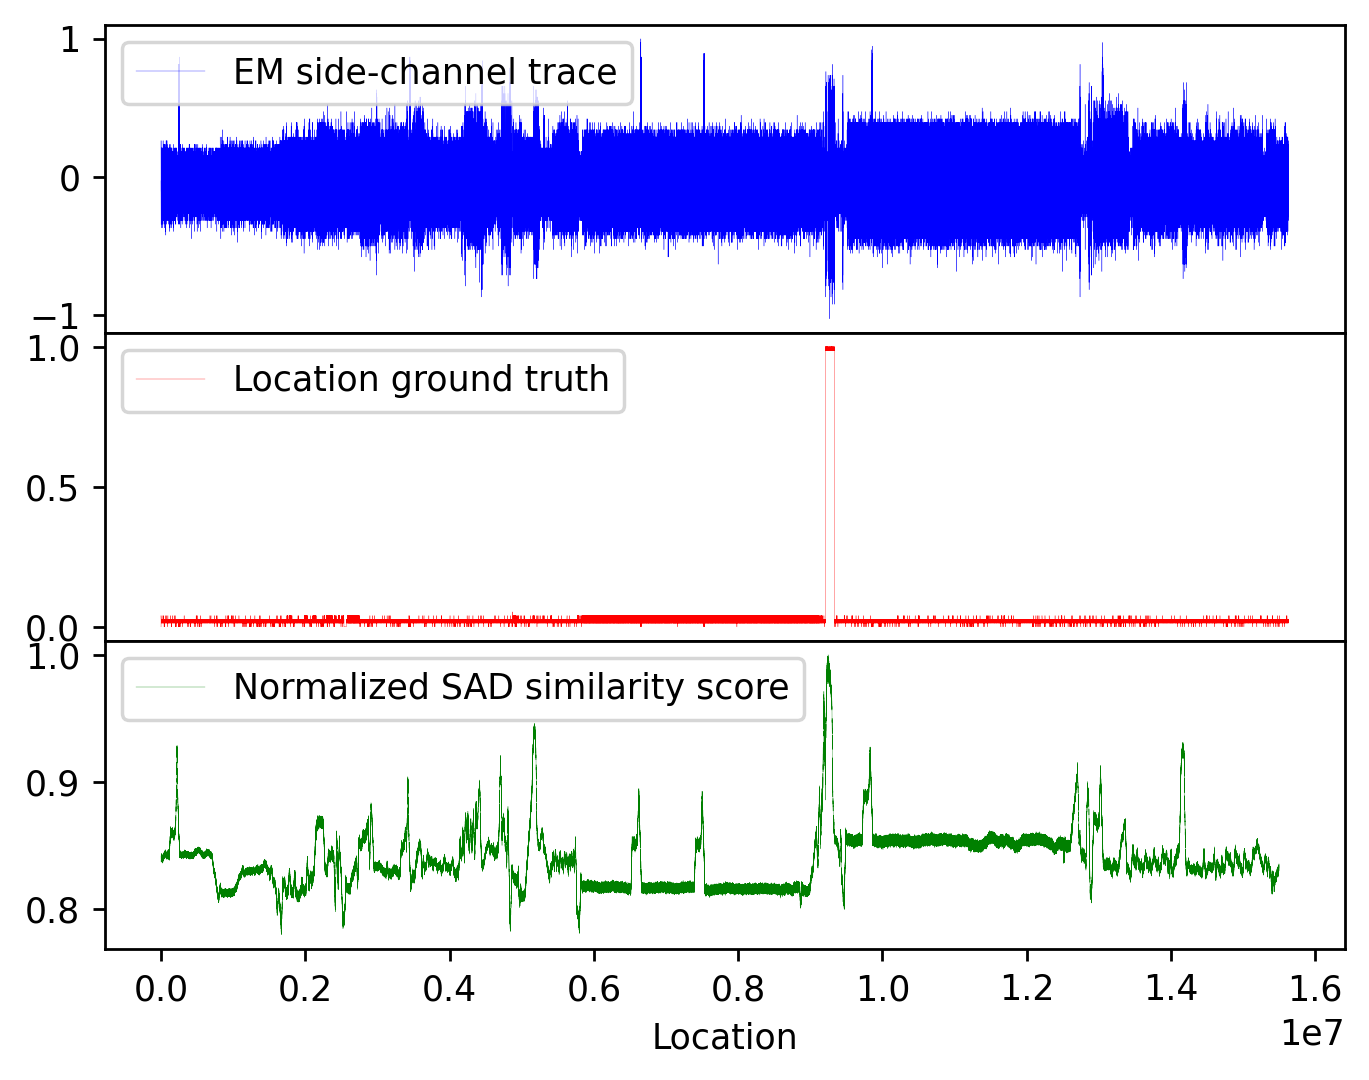

In [12]:
sad_kernel = cp.RawKernel(r'''
extern "C" __global__
void sad_similarity(const float *A, const float *B, float *results, int A_size, int B_size) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int num_windows = B_size - A_size + 1;

    if (idx < num_windows) {
        float sad_value = 0.0;

        for (int i = 0; i < A_size; i++) {
            sad_value += fabsf(A[i] - B[idx + i]);
        }

        results[idx] = sad_value;
    }
}
''', 'sad_similarity')

def sad_similarity_single_gpu(A, B):
    M = A.shape[0]
    N = B.shape[0]
    num_windows = N - M + 1
    A_gpu = cp.array(A, dtype=cp.float32)
    B_gpu = cp.array(B, dtype=cp.float32)

    results_gpu = cp.zeros(num_windows, dtype=cp.float32)

    threads_per_block = 256
    num_blocks = (num_windows + threads_per_block - 1) // threads_per_block
    sad_kernel((num_blocks,), (threads_per_block,), (A_gpu, B_gpu, results_gpu, M, N))

    results = results_gpu.get()

    best_index = int(np.argmin(results))

    return best_index, results

# downsample_factor = 1
# A = downsample_average(em_trace_target[edges_target[-2]:edges_target[-1]], downsample_factor)
# B = downsample_average(em_trace_full, downsample_factor)
# C = downsample_average(trigger_trace_full, downsample_factor)

# A = em_trace_target[edges_target[-2]:edges_target[-1]]
# B = em_trace_full
# C = trigger_trace_full

A = np.abs(em_trace_target[edges_target[-2]:edges_target[-1]])
B = np.abs(em_trace_full)
C = np.abs(trigger_trace_full)

best_index, results = sad_similarity_single_gpu(A, B)
# best_index, results = pearson_correlation_single_gpu(em_trace_target[edges_target[-2]:edges_target[-1]], em_trace_full)

print(best_index, np.max(results))


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, 
                                    gridspec_kw={'hspace': 0})
ax1.plot(em_trace_full/np.max(em_trace_full), color='blue', linewidth=0.1, label="EM side-channel trace")
ax1.legend(loc="upper left")
ax2.plot(C/np.max(C), color='red', linewidth=0.1, label="Location ground truth")
ax2.legend(loc="upper left")
ax3.plot(results/np.max(results), color='green', linewidth=0.1, label="Normalized SAD similarity score")
ax3.legend(loc="upper left")
ax3.set_xlabel('Location')

plt.savefig("uboot-sad-result.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0.1)

plt.show()

# similar_score_time = np.zeros(em_trace_full.shape[0])
# target_len = edges_target[-1] - edges_target[-2]
# # ~4 hours, unacceptable
# for i in tqdm(range(0, em_trace_full.shape[0])):
#     width = min(target_len, em_trace_full.shape[0] - i)
#     score, _ = pearsonr(em_trace_full[i:i+width], em_trace_target[:width])
#     similar_score_time[i] = score